<a href="https://colab.research.google.com/github/valeriopagliarino/Electronics-2021-UNITO/blob/main/analysis/1_Introduction_and_OPA_amplifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis: Introduction and OPA amplifiers
### October 4th 2021
<p>
Authors: <b> Stefano Barbero, Valerio Pagliarino, Matteo Barbagiovanni, Federico Malnati </b> <p>Electronics Laboratory 2021 - Department of Physics - University of Turin <p>
Date: 04/10/2021

1. Instrumentation configuration
2. Probe compensation
3. Half-wave diode rectifier
4. OPA zero crossing 
5. OPA inverting zero crossing
6. OPA slew rate frequency sweep
7. OPA open ring biased threshold
8. OPA closed loop non inverting G = 2
9. OPA closed loop non inverting G = 10
10. OPA closed loop inverting bode plots for G = 1
11. OPA closed loop inverting bode plots for G = 10

OPA: LM471CV (https://www.ti.com/lit/ds/symlink/lm741.pdf)


## Configuration

### Clone the GIT

In [1]:
!rm -r ./sample_data
import os
from getpass import getpass
user = input('GitHub user')
mail = input('GitHub email')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/valeriopagliarino/Electronics-2021-UNITO.git
!git config --global user.email user
!git config --global user.name mail

rm: cannot remove './sample_data': No such file or directory


KeyboardInterrupt: Interrupted by user

### Install environment

In [ ]:
exec(open("./Electronics-2021-UNITO/analysis/ROOT-config.py").read())

### Importa moduli [no COLAB]

In [2]:
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from matplotlib import pyplot as plt

from uncertainties import ufloat
import uncertainties.umath

import pickle

import ROOT # Per COLAB importato da ROOT-config.py

DATADIR = "../data-source"
OUTPUTDIR = "./output"

Welcome to JupyROOT 6.24/06


### Importa moduli [COLAB]

In [ ]:
%cd /content/
!pip3 install uncertainties
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from uncertainties import ufloat
import uncertainties.umath
from matplotlib import pyplot as plt
import pickle #Pickle with dict of Numpy arrays

# Variables for directories
DATADIR = "/content/Electronics-2021-UNITO/data-source"
OUTPUTDIR = "/content/Electronics-2021-UNITO/analysis/output"

### Funzioni per l'importazione file Tektronix

In [3]:
import csv

def cellFromCSV(path, row_index, col_index):
  with open(path, 'r') as f:
    mycsv = csv.reader(f)
    column = []
    for row in mycsv:
        column.append(row[col_index])

  return column[row_index]


def openTek(path):
  a = pd.read_table(path, header=None, sep=",", usecols=[3,4])
  a = a.transpose()
  a = a.rename(index={3: 'Time', 4: 'Amplitude'})
  a = a.transpose()

  data = {'Record lenght': cellFromCSV(path, 0, 1),
          'Sample interval': cellFromCSV(path, 1, 1),
          'Trigger point': cellFromCSV(path, 2, 1),
          'Source': cellFromCSV(path, 6, 1),
          'Vertical units': cellFromCSV(path, 7, 1),
          'Vertical scale': cellFromCSV(path, 8, 1),
          'Vertical offset': cellFromCSV(path, 9, 1),
          'Horizontal units': cellFromCSV(path, 10, 1),
          'Horizontal scale': cellFromCSV(path, 11, 1),
          'Pt FMT': cellFromCSV(path, 12, 1),
          'Y zero': cellFromCSV(path, 13, 1),
          'Probe atten': cellFromCSV(path, 14, 1),
          'Model': cellFromCSV(path, 15, 1),
          'Serial': cellFromCSV(path, 16, 1),
          'Firmware': cellFromCSV(path, 17, 1),
          'Data' : a
  }
  return data

## Half-wave rectifier

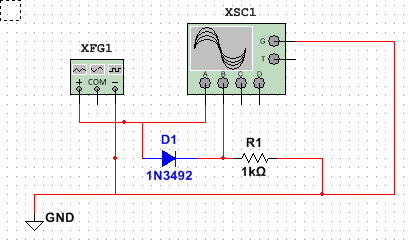

In [4]:
%cd /content

ch1_f = openTek(f'{DATADIR}/4-10-21/half_wave_rectifier_hi/F0002CH1.CSV')
ch2_f = openTek(f'{DATADIR}/4-10-21/half_wave_rectifier_hi/F0002CH2.CSV')
ch1_l = openTek(f'{DATADIR}/4-10-21/half_wave_rectifier_lo/F0003CH1.CSV')
ch2_l = openTek(f'{DATADIR}/4-10-21/half_wave_rectifier_lo/F0003CH2.CSV')
print(ch2_f.keys())

input_1 = ch1_f['Data'].to_numpy()
upper_half_wave = ch2_f['Data'].to_numpy()

input_2 = ch1_l['Data'].to_numpy()
lower_half_wave = ch2_l['Data'].to_numpy()

time1 = upper_half_wave.transpose()[0]
time2 = lower_half_wave.transpose()[0]
input_1  = input_1.transpose()[1]
input_2  = input_2.transpose()[1]
upper   = upper_half_wave.transpose()[1]
lower   = lower_half_wave.transpose()[1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time1 * 1e3, upper, label = "Semionda positiva", color = 'red')
ax.plot(time2 * 1e3, lower, label = "Semionda negativa", color = 'blue')
ax.plot(time1 * 1e3, input_1, label = "Sinusoide in ingresso", color = 'black', linestyle = "--")

max_rt = upper[1250:1900].max()
max_in = input_1[1250:1900].max()

ax.hlines(max_rt, -0.25, .5)
ax.hlines(max_in, -0.25, .5)
ax.arrow(-0.20, max_rt, 0, abs(max_rt - max_in) - 0.18,  head_width = 0.08, color = "black")
ax.arrow(-0.20, max_rt + abs(max_rt - max_in), 0, -1.* abs(max_rt - max_in) + 0.18,  head_width = 0.08, color = "black")

ax.text(-0.40, max_rt + abs(max_rt - max_in) - 0.1, 'ΔV',
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=15)

ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title='Raddrizzatore a singola semionda con diodo al silicio')
ax.grid()
ax.legend(loc = "lower right")
plt.savefig(f"{OUTPUTDIR}/half-wave-rectifier.pdf")

print("\nValore di Delta V = ", abs(max_rt - max_in), " V")

SyntaxError: EOL while scanning string literal (2533885335.py, line 43)

## OPA open-loop non-inverting zero-crossing detector

In [ ]:
ch1_f = openTek(f'{DATADIR}/4-10-21/OPA_zero_crossing/F0007CH1.CSV')
ch2_f = openTek(f'{DATADIR}/4-10-21/OPA_zero_crossing/F0007CH2.CSV')

time1 = ch1_f['Data'].to_numpy().transpose()[0] * 1000
ch1   = ch1_f['Data'].to_numpy().transpose()[1]
time2 = ch2_f['Data'].to_numpy().transpose()[0] * 1000
ch2   = ch2_f['Data'].to_numpy().transpose()[1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time1, ch1, color = "black", label = "Sinusoide in ingresso")
ax.plot(time2, ch2, color = "blue", label = "Uscita OPA")



ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title='Amplificatore operazionale in configurazione ad anello aperto \n per la rilevazione del punto di zero-crossing, non invertente')

ax.grid()
ax.legend(bbox_to_anchor=(0.5, 0., 0.5, 0.5))

plt.savefig(f"{OUTPUTDIR}/OPA-open-loop-non-inv-zero-crossing.pdf")

In [ ]:
ch1_f = openTek(f'{DATADIR}/4-10-21/OPA_zero_crossing/F0007CH1.CSV')
ch2_f = openTek(f'{DATADIR}/4-10-21/OPA_zero_crossing/F0007CH2.CSV')

time1 = ch1_f['Data'].to_numpy().transpose()[0] * 1000
ch1   = ch1_f['Data'].to_numpy().transpose()[1]
time2 = ch2_f['Data'].to_numpy().transpose()[0] * 1000
ch2   = ch2_f['Data'].to_numpy().transpose()[1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time1, ch1, color = "black", label = "Sinusoide in ingresso")
ax2 = ax.twinx()
ax2.plot(time2, ch2, color = "blue", label = "Uscita OPA")

ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V) [segnale in uscita in blu]',
       title='Amplificatore operazionale in configurazione ad anello aperto \n per la rilevazione del punto di zero-crossing, non invertente')

ax.grid()
#ax2.grid()
ax2.set(ylabel='Ampiezza del segnale (V) [sinusoide in ingresso in nero]')
#ax.legend(bbox_to_anchor=(0.5, 0., 0.5, 0.5))
#ax2.legend(bbox_to_anchor=(0.5, 0.1, 0.5, 0.5))

plt.savefig(f"{OUTPUTDIR}/OPA-open-loop-non-inv-zero-crossing-z2.pdf")

## OPA open-loop inverting zero-crossing detector

In [ ]:
ch1_f = openTek(f'{DATADIR}/4-10-21/OPA_zero_crossing_inverting/F0013CH1.CSV')
ch2_f = openTek(f'{DATADIR}/4-10-21/OPA_zero_crossing_inverting/F0013CH2.CSV')

time1 = ch1_f['Data'].to_numpy().transpose()[0] * 1000
ch1   = ch1_f['Data'].to_numpy().transpose()[1]
time2 = ch2_f['Data'].to_numpy().transpose()[0] * 1000
ch2   = ch2_f['Data'].to_numpy().transpose()[1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time1, ch1, color = "black", label = "Sinusoide in ingresso")
ax.plot(time2, ch2, color = "red", label = "Uscita OPA")

ax.hlines(0, -1.1, 1.35, linestyle = "--", color="black")

ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title='Amplificatore operazionale in configurazione ad anello aperto \n per la rilevazione del punto di zero-crossing, invertente')

ax.grid()
ax.legend(bbox_to_anchor=(0.5, 0., 0.5, 0.5))

plt.savefig(f"{OUTPUTDIR}/OPA-open-loop-inv-zero-crossing.pdf")

In [ ]:
ch1_f = openTek(f'{DATADIR}/4-10-21/OPA_zero_crossing_inverting/F0013CH1.CSV')
ch2_f = openTek(f'{DATADIR}/4-10-21/OPA_zero_crossing_inverting/F0013CH2.CSV')

time1 = ch1_f['Data'].to_numpy().transpose()[0] * 1000
ch1   = ch1_f['Data'].to_numpy().transpose()[1]
time2 = ch2_f['Data'].to_numpy().transpose()[0] * 1000
ch2   = ch2_f['Data'].to_numpy().transpose()[1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time1, ch1, color = "black", label = "Sinusoide in ingresso")
ax2 = ax.twinx()
ax2.plot(time2, ch2, color = "red", label = "Uscita OPA")

ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V) [segnale in uscita in rosso]',
       title='Amplificatore operazionale in configurazione ad anello aperto \n per la rilevazione del punto di zero-crossing, invertente')

ax.hlines(0, -1.1, 1.35, linestyle = "--", color="black")

ax.grid()
#ax2.grid()
ax2.set(ylabel='Ampiezza del segnale (V) [sinusoide in ingresso in nero]')
#ax.legend(bbox_to_anchor=(0.5, 0., 0.5, 0.5))
#ax2.legend(bbox_to_anchor=(0.5, 0.1, 0.5, 0.5))

plt.savefig(f"{OUTPUTDIR}/OPA-open-loop-inv-zero-crossing-z2.pdf")

## OPA open loop biased threshold @2.1 V

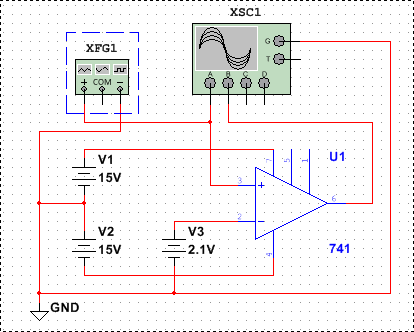

In [ ]:
Vth = 2.1 # V

ch1_f = openTek(f'{DATADIR}/4-10-21/OPA_open_ring_biased_threshold/F0012CH1.CSV')
ch2_f = openTek(f'{DATADIR}/4-10-21/OPA_open_ring_biased_threshold/F0012CH2.CSV')

time1 = ch1_f['Data'].to_numpy().transpose()[0] * 1000
ch1   = ch1_f['Data'].to_numpy().transpose()[1]
time2 = ch2_f['Data'].to_numpy().transpose()[0] * 1000
ch2   = ch2_f['Data'].to_numpy().transpose()[1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time1, ch1, color = "black", label = "Sinusoide in ingresso")
ax.plot(time2, ch2, color = "blue", label = "Uscita OPA")

#ax.hlines(0, -1.15, 1.5, linestyle = "--", color="gray")

ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title='Amplificatore operazionale in configurazione ad anello aperto \n soglia a tensione $V_{th}$ > 0, non invertente')

ax.text(-1.15, 4, '$V_{th}$',
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=15)

ax.hlines(Vth, -1.15, 1.5, linestyle = "--")

ax.grid()
ax.legend(loc=(0.65, 0.1))

plt.savefig(f"{OUTPUTDIR}/OPA-open-loop-biased_threshold.pdf")

## OPA closed loop non inverting

In [ ]:
ch1_11 = openTek(f'{DATADIR}/4-10-21/OPA_closed_loop_non_inverting_G11/F0017CH1.CSV')
ch2_11 = openTek(f'{DATADIR}/4-10-21/OPA_closed_loop_non_inverting_G11/F0017CH2.CSV')
ch1_2  = openTek(f'{DATADIR}/4-10-21/OPA_closed_loop_non_inverting_G2/F0016CH1.CSV')
ch2_2  = openTek(f'{DATADIR}/4-10-21/OPA_closed_loop_non_inverting_G2/F0016CH2.CSV')

time1  = ch1_11['Data'].to_numpy().transpose()[0] * 1000
input1 = ch1_11['Data'].to_numpy().transpose()[1]

time2  = ch1_2['Data'].to_numpy().transpose()[0] * 1000
input2 = ch1_2['Data'].to_numpy().transpose()[1]

time3  = ch2_11['Data'].to_numpy().transpose()[0] * 1000
outG11 = ch2_11['Data'].to_numpy().transpose()[1]

time4  = ch2_2['Data'].to_numpy().transpose()[0] * 1000
outG2  = ch2_2['Data'].to_numpy().transpose()[1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time1, input1, color = "black", label = "Sinusoide in ingresso")
ax.plot(time1, outG11, color = "red", label = "Uscita OPA G=11")
ax.plot(time2, outG2, color = "blue", label = "Uscita OPA G=2")



ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title='Amplificatore operazionale in configurazione\n ad anello chiuso non invertente')

ax.grid()
ax.legend(loc="lower left")

e1 = "$\sim $" + str(input1.max()) + " V"
e2 = "$\sim $" + str(outG2.max()) + " V"
e3 = "$\sim $" + str(outG11.max()) + " V"


ax.text(-1.46, input1.max() - 0.05, e1,
        verticalalignment='top', horizontalalignment='left',
        color='black', fontsize=11)
ax.hlines(input1.max(), -1.38, 1.5, linestyle = "--")

ax.text(-1.46, outG2.max() + 0.25, e2,
        verticalalignment='top', horizontalalignment='left',
        color='blue', fontsize=11)
ax.hlines(outG2.max(), -1.38, 1.5, linestyle = "--", color="blue")

ax.text(-1.46, outG11.max() - 0.05, e3,
        verticalalignment='top', horizontalalignment='left',
        color='red', fontsize=11)
ax.hlines(outG11.max(), -1.38, 1.5, linestyle = "--", color="red")

plt.savefig(f"{OUTPUTDIR}/OPA-closed-loop-non-inv-G2-11.pdf")

## OPA Slew Rate vs freq

In [ ]:
in_100K  = openTek(f'{DATADIR}/4-10-21/OPA_or_slew_rate_100KHz/F0008CH1.CSV')
out_100K = openTek(f'{DATADIR}/4-10-21/OPA_or_slew_rate_100KHz/F0008CH2.CSV')
in_50K   = openTek(f'{DATADIR}/4-10-21/OPA_or_slew_rate_50KHz/F0009CH1.CSV')
out_50K  = openTek(f'{DATADIR}/4-10-21/OPA_or_slew_rate_50KHz/F0009CH2.CSV')
in_10K   = openTek(f'{DATADIR}/4-10-21/OPA_or_slew_rate_10KHz/F0010CH1.CSV')
out_10K  = openTek(f'{DATADIR}/4-10-21/OPA_or_slew_rate_10KHz/F0010CH2.CSV')
in_5K    = openTek(f'{DATADIR}/4-10-21/OPA_or_slew_rate_5KHz/F0011CH1.CSV')
out_5K   = openTek(f'{DATADIR}/4-10-21/OPA_or_slew_rate_5KHz/F0011CH2.CSV')

in_100K_time  = in_100K['Data'].to_numpy().transpose()[0] * 1000
in_100K_sig   = in_100K['Data'].to_numpy().transpose()[1]
out_100K_time  = out_100K['Data'].to_numpy().transpose()[0] * 1000
out_100K_sig   = out_100K['Data'].to_numpy().transpose()[1]

in_50K_time  = in_50K['Data'].to_numpy().transpose()[0] * 1000
in_50K_sig   = in_50K['Data'].to_numpy().transpose()[1]
out_50K_time  = out_50K['Data'].to_numpy().transpose()[0] * 1000
out_50K_sig   = out_50K['Data'].to_numpy().transpose()[1]

in_10K_time  = in_10K['Data'].to_numpy().transpose()[0] * 1000
in_10K_sig   = in_10K['Data'].to_numpy().transpose()[1]
out_10K_time  = out_10K['Data'].to_numpy().transpose()[0] * 1000
out_10K_sig   = out_10K['Data'].to_numpy().transpose()[1]

in_5K_time  = in_5K['Data'].to_numpy().transpose()[0] * 1000
in_5K_sig   = in_5K['Data'].to_numpy().transpose()[1]
out_5K_time  = out_5K['Data'].to_numpy().transpose()[0] * 1000
out_5K_sig   = out_5K['Data'].to_numpy().transpose()[1]


fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(12, 9))

#Remove DC offset
in_100K_sig  = in_100K_sig - in_100K_sig.mean()
in_50K_sig   = in_50K_sig - in_50K_sig.mean()
in_10K_sig   = in_10K_sig - in_10K_sig.mean()
in_5K_sig    = in_5K_sig - in_5K_sig.mean()

out_100K_sig = out_100K_sig - out_100K_sig.mean()
out_50K_sig  = out_50K_sig  - out_50K_sig.mean()
out_10K_sig  = out_10K_sig  - out_10K_sig.mean()
out_5K_sig   = out_5K_sig   - out_5K_sig.mean()

ax2 = []
for ax_2 in ax:
  ax2.append(ax_2.twinx())

ax[0].plot(in_100K_time, in_100K_sig, color = "black", label = "Ingresso 100 KHz")
ax2[0].plot(out_100K_time, out_100K_sig, color = "blue", label = "Uscita OPA")

ax[1].plot(in_50K_time, in_50K_sig, color = "black", label = "Ingresso 50 KHz")
ax2[1].plot(out_50K_time, out_50K_sig, color = "blue", label = "Uscita OPA")

ax[2].plot(in_10K_time, in_10K_sig, color = "black", label = "Ingresso 10 KHz")
ax2[2].plot(out_10K_time, out_10K_sig, color = "blue", label = "Uscita OPA")

ax[3].plot(in_5K_time, in_5K_sig, color = "black", label = "Ingresso 5 KHz")
ax2[3].plot(out_5K_time, out_5K_sig, color = "blue", label = "Uscita OPA")


for ax_ in ax:
  ax_.grid()
  #ax_.legend(loc="upper left")


plt.savefig(f"{OUTPUTDIR}/OPA-open-loop-slew-rate.pdf")

Regressione lineare nella regione di commutazione del trigger ad anello aperto per il calcolo dello slew rate (misura a 100 KHz)

In [ ]:
%cd /content
import scipy.stats

fig, ax = plt.subplots()

in_ = 290
out_ = 470
tbase = out_100K_time[in_: out_]
verts = out_100K_sig[in_: out_]

ax.plot(tbase, verts, color = "black")

res = sp.stats.linregress(tbase, verts)
y = res[0] * tbase + res[1]
ax.plot(tbase, y, color = "blue")
print(res)
print("Slew rate = ", res[0] / 1000, " V/us")

ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (V)',
       title='Regressione lineare per la valutazione dello slew rate')

ax.grid()

plt.savefig(f"{OUTPUTDIR}/OPA-slew-rate-fit.pdf")

## Commit changes

In [ ]:
%cd /content/Electronics-2021-UNITO/
!git pull
!git add .
!git commit -m "Plots from data analysis"
!git push 